In [30]:
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

from pilco.policies import RBFPolicy, TransformedPolicy
from pilco.transforms import SineTransform

import matplotlib.pyplot as plt

In [121]:
def plot_pendulum_policy(policy, s_points=60, s_dot_points=30):
    s_linspace = tf.cast(tf.linspace(-3*np.pi, 2 * np.pi, s_points), dtype=tf.float64)

    s_dot_linspace = tf.cast(tf.linspace(-8., 8., s_dot_points), dtype=tf.float64)

    s_grid, s_dot_grid = tf.meshgrid(s_linspace, s_dot_linspace)

    grid = tf.stack([s_grid, s_dot_grid], axis=-1)

    grid = tf.reshape(grid, (-1, 2))
    
    actions = tf.stack([t_policy(point) for point in grid], axis=0)
    actions = tf.reshape(actions, (s_dot_points, s_points))
    
    centroids = rbf_policy.rbf_locs().numpy()

    plt.figure(figsize=(12, 8))
    contour = plt.contourf(s_grid, s_dot_grid, actions, cmap='coolwarm', alpha=0.5, vmin=-2, vmax=2)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='k')
    cbar = plt.colorbar(contour)
    plt.xlabel("Theta")
    plt.ylabel("Theta dot")
    plt.tight_layout()
    plt.show()

In [122]:
rbf_policy = RBFPolicy(state_dim=2, 
                       action_dim=1, 
                       num_rbf_features=10,
                       dtype=tf.float64)

t_policy = TransformedPolicy(policy=rbf_policy,
                             transform=SineTransform(lower=-2,
                                                     upper=2))

#t_policy.reset()

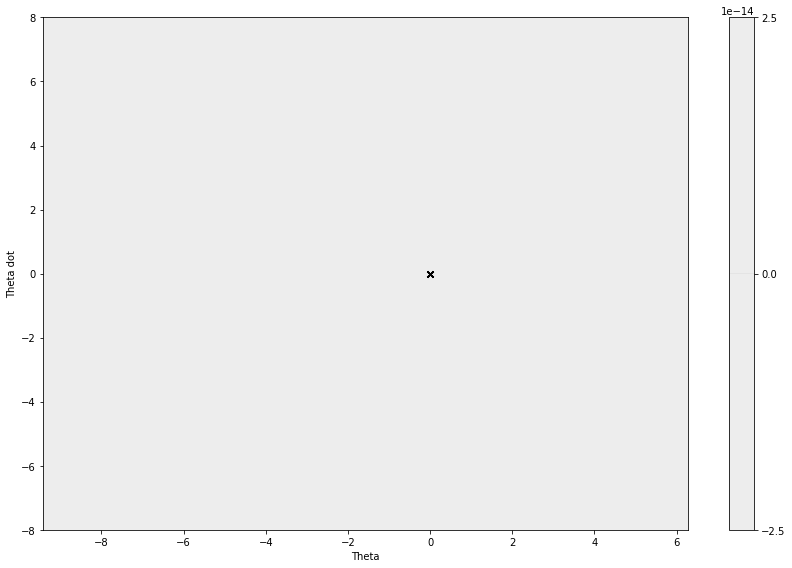

In [123]:
plot_pendulum_policy(t_policy)

In [8]:
import tensorflow as tf

indices = [[1, 0]]
params = [[3, 4]]

tf.gather_nd(params, indices)

InvalidArgumentError: indices[0] = [1, 0] does not index into param shape [1,2] [Op:GatherNd]

In [1]:
import gpflow as gpf
import tensorflow as tf
from pilco.utils import chol_update_by_block_lu

In [4]:
X = 2. * tf.random.uniform(shape=(10, 2), dtype=tf.float64) - 1.
X = tf.Variable(X)

kernel = gpf.kernels.Matern52()

K = kernel(X, X)
print(K)
K = K # + 1e-1 * tf.eye(K.shape[0], dtype=tf.float64)

M = tf.linalg.cholesky(K)
print(M)
L = tf.linalg.cholesky(K[:-1, :-1])
M_ = chol_update_by_block_lu(L, K[:-1, -1:], K[-1:, -1:])
print(M_)

print(tf.matmul(M_, M_, transpose_b=True) - K)
print(M - M_)

tf.Tensor(
[[1.         0.21674113 0.17865304 0.52228457 0.7632925  0.59323544
  0.60337381 0.31356909 0.37162798 0.53519752]
 [0.21674113 1.         0.95395546 0.69152875 0.24464956 0.61553315
  0.25053339 0.68886949 0.67775989 0.27575163]
 [0.17865304 0.95395546 1.         0.62655219 0.1854259  0.55215652
  0.24408423 0.54119152 0.53363753 0.27559946]
 [0.52228457 0.69152875 0.62655219 1.         0.47375879 0.98748031
  0.56990337 0.62664254 0.6896264  0.59074073]
 [0.7632925  0.24464956 0.1854259  0.47375879 1.         0.51868423
  0.32833568 0.47109436 0.5349076  0.29411366]
 [0.59323544 0.61553315 0.55215652 0.98748031 0.51868423 1.
  0.62537491 0.59028352 0.65938802 0.63758731]
 [0.60337381 0.25053339 0.24408423 0.56990337 0.32833568 0.62537491
  1.         0.21221369 0.25109686 0.98320545]
 [0.31356909 0.68886949 0.54119152 0.62664254 0.47109436 0.59028352
  0.21221369 1.         0.9855115  0.21525364]
 [0.37162798 0.67775989 0.53363753 0.6896264  0.5349076  0.65938802
  0.25109

In [7]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [24]:
loc = tf.Variable(tf.ones((3,), dtype=tf.float64))
scale_tril = tf.Variable(tf.eye(3, dtype=tf.float64))

dist = tfd.MultivariateNormalTriL(loc=loc,
                                  scale_tril=scale_tril)

with tf.GradientTape() as tape:
    
    sample = dist.sample(1000)
    sample = tf.abs(sample)
    
    loss = tf.reduce_sum(sample) / 1000
    
    
tape.gradient(loss, scale_tril)

<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[ 0.44468665,  0.        ,  0.        ],
       [-0.0232489 ,  0.44973914,  0.        ],
       [ 0.00597904,  0.03946129,  0.44827384]])>

In [51]:
print(X.shape)
print(X[None, None, :-5, :].shape, X[None, None, :-7, :].shape)
K = kernel(X[None, None, :-5, :], X[None, None, :-6, :][(0, 0)])

K.shape

(10, 2)
(1, 1, 5, 2) (1, 1, 3, 2)


TensorShape([1, 1, 5, 4])

In [66]:
normal = tfd.Normal(loc=10*tf.eye(3), scale=tf.eye(3))

normal.sample().shape

TensorShape([3, 3])

In [1]:
from pilco.environments import Environment
from pilco.costs import EQCost
from pilco.agents.exploration_agents import GPExplorationAgent
from pilco.policies import BatchedEQPolicy, TransformedPolicy
from pilco.transforms import SineTransform

import tensorflow as tf
import tensorflow_probability as tfp
import gpflow as gpf

import numpy as np
import matplotlib.pyplot as plt

In [8]:
dtype = tf.float64
tf.random.set_seed(1)
np.random.seed(1)

# Create pendulum environment and reset
env = Environment(name='Pendulum-v0',
                  sub_sampling_factor=2)
env.reset()

eq_policy = BatchedEQPolicy(state_dim=2,
                            action_dim=1,
                            num_eq_features=10,
                            dtype=dtype)

gp_means = []
gp_covs = [gpf.kernels.RBF(variance=1., lengthscales=[np.pi, 8., 1.]),
           gpf.kernels.RBF(variance=1., lengthscales=[np.pi, 8., 1.])]

gp_exploration_agent = GPExplorationAgent(state_dim=2,
                                          action_dim=1,
                                          gp_means=gp_means,
                                          gp_covs=gp_covs,
                                          policy=eq_policy,
                                          dtype=tf.float64)

gp_exploration_agent.policy.reset()

theta = - 0.5 * np.pi

for episode in range(2):

    state = env.reset()
    gp_exploration_agent.policy.reset()

    state = np.array([theta + 0.1 * np.random.rand(), 0.])
    env.env.env.state = state

    for step in range(10):
        action = gp_exploration_agent.policy(state[None, :])[:, 0]
        state, action, next_state = env.step(action.numpy())

        gp_exploration_agent.observe(state, action, next_state)

In [9]:
state_dist = tfp.distributions.Normal(loc= theta * tf.ones(2, dtype=tf.float64), scale=tf.zeros(1, dtype=tf.float64))
num_rollouts = 20
horizon = 100

rec_inputs, rec_outputs, rec_states = gp_exploration_agent.rollout(state_dist=state_dist,
                                                                   num_rollouts=num_rollouts,
                                                                   horizon=horizon,
                                                                   recondition=True)

not_inputs, not_outputs, not_states = gp_exploration_agent.rollout(state_dist=state_dist,
                                                                   num_rollouts=num_rollouts,
                                                                   horizon=horizon,
                                                                   recondition=False)

state = np.array([theta, 0.])
env.env.env.state = state

real_states = [state]

for step in range(horizon):
    
    action = gp_exploration_agent.policy(state[None, :])[:, 0]
    state, action, next_state = env.step(action.numpy())

    state = next_state
    real_states.append(state)
    
real_states = np.stack(real_states, axis=-1)

(-15, 15)

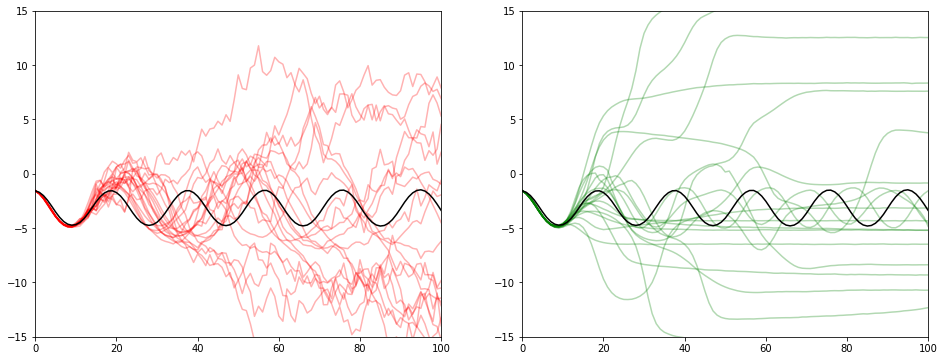

In [10]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
for i in range(num_rollouts):
    plt.plot(np.arange(horizon + 1), not_states[i, 0, 0].numpy(), color='red', alpha=0.3)
plt.plot(np.arange(horizon + 1), real_states[0, :], color='k')
    
    
plt.xlim([0, horizon])
plt.ylim([-15, 15])

plt.subplot(122)
for i in range(num_rollouts):
    plt.plot(np.arange(horizon + 1), rec_states[i, 0, 0].numpy(), color='green', alpha=0.3)
    
plt.plot(np.arange(horizon + 1), real_states[0, :], color='k')
    
plt.xlim([0, horizon])
plt.ylim([-15, 15])

In [16]:
loc = tf.stack([tf.zeros(3)] * 10, axis=0)
scale = tf.stack([tf.eye(3)] * 10, axis=0)

print(loc.shape, scale.shape)

dist = tfp.distributions.MultivariateNormalFullCovariance(loc=loc, scale=scale)

dist.kl_divergence(dist)

(10, 3) (10, 3, 3)
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


TypeError: __init__() got an unexpected keyword argument 'scale'

In [54]:
chol = tf.eye(3, dtype=tf.float64)
v = tf.random.uniform(shape=(3, 1), dtype=tf.float64)
v = v / (10 * tf.reduce_sum(v * v) ** 0.5)
A = tf.matmul(chol, chol, transpose_b=True) - tf.matmul(v, v, transpose_b=True)

print(tf.linalg.cholesky(A))

def cholesky_update(L, u):
    
    w = tf.linalg.triangular_solve(L, u)
    print(w)
    gamma = (1. - tf.reduce_sum(u * u)) ** 0.5 - 1.
    
    w_w_T = tf.matmul(w, w, transpose_b=True)
    gamma_w_w_T = gamma * w_w_T / tf.reduce_sum(w ** 2)
    
    eye_plus_gamma_w_w_T = tf.eye(L.shape[0], dtype=tf.float64) + gamma_w_w_T
    
    L_new = tf.matmul(L, eye_plus_gamma_w_w_T)
    
cholesky_update(chol, v)
# print(A)


tf.Tensor(
[[ 0.99766343  0.          0.        ]
 [-0.00352425  0.99866865  0.        ]
 [-0.00354767 -0.00268218  0.99864728]], shape=(3, 3), dtype=float64)
tf.Tensor(
[[0.06832041]
 [0.05146356]
 [0.05180564]], shape=(3, 1), dtype=float64)
tf.Tensor([ 0.99765715 -0.0017648   0.        ], shape=(3,), dtype=float64)
